## Imports

In [56]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

## Daten Import and Vorbereitung

In [57]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/animal-faces")
path2 = kagglehub.dataset_download("antobenedetti/animals")

print("Path to dataset files:", path)
print("Path to dataset 2 files:", path2)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = datasets.ImageFolder(os.path.join(path2, 'animals/train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(path2, 'animals/val'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

classes = train_dataset.classes
print(f"Classes: {classes}")

Path to dataset files: /kaggle/input/animal-faces
Path to dataset 2 files: /kaggle/input/animals
Classes: ['cat', 'dog', 'elephant', 'horse', 'lion']


## CNN Modell

In [58]:
class AnimalCNN(nn.Module):
    def __init__(self, num_classes):
        super(AnimalCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

## Training

In [59]:
device2 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device2)
model = AnimalCNN(num_classes=len(classes)).to(device)

print("device:", device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device: cuda


In [60]:
epochs = 10
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")


Epoch 1/10: 100%|██████████| 422/422 [01:05<00:00,  6.47it/s, loss=1.67]


Epoch 1 Average Loss: 0.8627


Epoch 2/10: 100%|██████████| 422/422 [01:06<00:00,  6.31it/s, loss=0.141]


Epoch 2 Average Loss: 0.5017


Epoch 3/10: 100%|██████████| 422/422 [01:07<00:00,  6.26it/s, loss=0.1]


Epoch 3 Average Loss: 0.3652


Epoch 4/10: 100%|██████████| 422/422 [01:06<00:00,  6.35it/s, loss=0.481]


Epoch 4 Average Loss: 0.2649


Epoch 5/10: 100%|██████████| 422/422 [01:05<00:00,  6.45it/s, loss=0.0264]


Epoch 5 Average Loss: 0.1767


Epoch 6/10: 100%|██████████| 422/422 [01:06<00:00,  6.31it/s, loss=0.232]


Epoch 6 Average Loss: 0.1091


Epoch 7/10: 100%|██████████| 422/422 [01:07<00:00,  6.26it/s, loss=0.00261]


Epoch 7 Average Loss: 0.0772


Epoch 8/10: 100%|██████████| 422/422 [01:06<00:00,  6.37it/s, loss=0.019]


Epoch 8 Average Loss: 0.0387


Epoch 9/10: 100%|██████████| 422/422 [01:05<00:00,  6.40it/s, loss=0]


Epoch 9 Average Loss: 0.0499


Epoch 10/10: 100%|██████████| 422/422 [01:06<00:00,  6.38it/s, loss=0.0205]

Epoch 10 Average Loss: 0.0372


### Training Loss

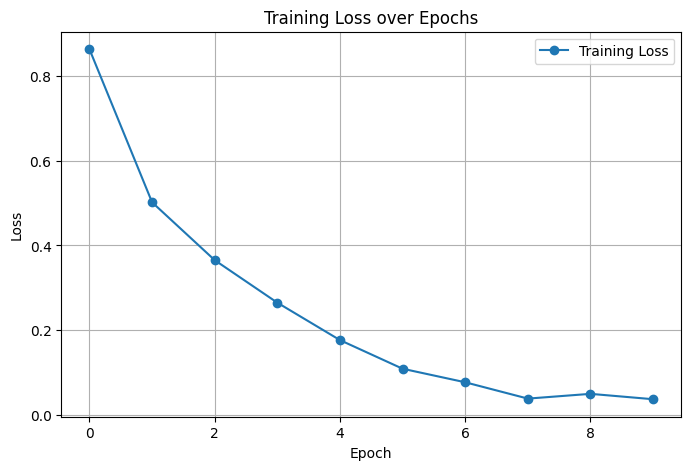

In [61]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, marker='o', label='Training Loss')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Evaluation

In [62]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 82.77%


## Klassifizierung eines Bildes

In [63]:
from PIL import Image
import torchvision.transforms as transforms

def classify_image(image, model, class_names, device):
    # Transform must match training preprocessing
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    # Load and preprocess image

    image = transform(image).unsqueeze(0).to(device)  # add batch dimension

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return class_names[predicted.item()]

In [64]:
image_path = os.path.join(path2, 'animals/val/dog/dog117.jpg')
image = Image.open(image_path).convert("RGB")
result = classify_image(image, model, classes, device)
print("Predicted class:", result)


Predicted class: dog
